In [ ]:
# buat ai llama
!pip install groq
# buat crossref
!pip install habanero

!pip install bs4
!pip install pandas
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3


In [ ]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import time
import functools
import seaborn as sns
import matplotlib.pyplot as plt

from habanero import Crossref
from bs4 import BeautifulSoup
from groq import Groq
from time import sleep
from urllib.parse import quote_plus

# constant -> isi sesuai kebutuhan

# min 2
keywords = ['Supercapacitor', 'carbon', 'porous']
# rentang, ada min dan max-> contoh dibawah 2022-2024
years = [2024,2022]
ARXIV_API_URL = "http://export.arxiv.org/api/query"
cr = Crossref()


# api key buat scraperapi biar bisa fetch scholar ga kena block ip
BASE_URL = "https://api.scraperapi.com/"
SCRAPER_API_KEY = "scraperapi"


# groq -> pake beberapa api key soalnya ada limit kalo gratis, kalo ga pengen ditambah info AI gausah diisi tetep dibikin csvnya
groq_api_keys = [
    "api1",
    "api2",
    "dll"
]

# jumlah artikel via arxiv, crossref, scholar
arxiv_qty = 999
crossref_qty = 999
scholar_qty = 999

In [ ]:
## dekorator loging

def log_function_call(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        print(f"Calling function: {func.__name__}")
        print(f"Arguments: {args}, {kwargs}")
        result = func(*args, **kwargs)
        print(f"Function {func.__name__} returned: {result}")
        return result
    return wrapper

def measure_execution_time(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time for {func.__name__}: {execution_time:.4f} seconds")
        return result
    return wrapper

In [ ]:
#main class

class ResearchScraper:
    def __init__(self, keywords, years, api_key=None, match=True, arxiv_max_results=1000, scholar_max_results = 1000, crossref_max_results = 1000):
        self.keywords = keywords
        self.years = years
        self.api_key = api_key
        self.match = match
        self.arxiv_max_results = arxiv_max_results
        self.scholar_max_results = scholar_max_results
        self.crossref_max_results = crossref_max_results

    # ARXIV Query Generator
    @log_function_call
    def generate_arxiv_query(self):
        if self.match:
            query = "+AND+".join([f"all:{keyword}" for keyword in self.keywords])
        else:
            query = "+AND+".join([f"all:{keyword}" for keyword in self.keywords[:2]])

        min_year = min(self.years)
        max_year = max(self.years)
        return query, min_year, max_year

    @measure_execution_time
    def scrape_arxiv(self):
        base_url = "http://export.arxiv.org/api/query?"
        all_results = []
        start = 0
        query, min_year, max_year = self.generate_arxiv_query()

        while len(all_results) < self.arxiv_max_results:
            url = f"{base_url}search_query={query}&start={start}&max_results=100&sortBy=submittedDate&sortOrder=descending"
            if min_year and max_year:
                url += f"&date-filter=all&from_year={min_year}&to_year={max_year}"

            response = requests.get(url)

            if response.status_code != 200:
                print(f"Error: {response.status_code}")
                break

            soup = BeautifulSoup(response.text, 'xml')
            entries = soup.find_all('entry')

            if not entries:
                print("No entries found in response.")
                break

            for entry in entries:
                title = entry.title.text if entry.title else "No Title"
                link = entry.id.text if entry.id else "No Link"
                abstract = entry.summary.text if entry.summary else ""
                year = entry.published.text.split("-")[0] if entry.published else "Unknown"
                citation = 0

                authors = [author.text for author in entry.find_all('author')] if entry.find_all('author') else ["Unknown Author"]

                publisher = entry.find('journal_ref').text if entry.find('journal_ref') else "ArXiv PrePrint"

                all_results.append({
                    "Title": title,
                    "Link": link,
                    "Abstract": abstract,
                    "Year": year,
                    "Author": ", ".join(authors),
                    "Publisher": publisher,
                    "Citation": citation,
                    "Source": "arxiv"
                })

            if len(entries) < 100:
                break

            start += 100

        return pd.DataFrame(all_results)

    @log_function_call
    def generate_scholar_query(self):
        if self.match:
            query = "+".join(self.keywords)
        else:
            query = "+".join(self.keywords[:2])

        min_year = min(self.years) if len(self.years) > 0 else None
        max_year = max(self.years) if len(self.years) > 0 else None
        return query, min_year, max_year


    @measure_execution_time
    def scrape_google_scholar(self):
        base_url = "https://scholar.google.com/scholar"
        scraperapi_url = "http://api.scraperapi.com"
        all_results = []
        start = 0
        query, min_year, max_year = self.generate_scholar_query()

        while len(all_results) < self.scholar_max_results:
            scholar_url = f"{base_url}?q={query}&start={start}&hl=en"
            if min_year and max_year:
                scholar_url += f"&as_ylo={min_year}&as_yhi={max_year}"
                print(scholar_url)

            params = {
                'api_key': self.api_key,
                'url': scholar_url
            }

            response = requests.get(scraperapi_url, params=params)

            if response.status_code != 200:
                print(f"Error: {response.status_code}")
                break

            soup = BeautifulSoup(response.text, 'html.parser')
            articles = soup.select(".gs_r")

            for article in articles:
                title_tag = article.select_one(".gs_rt a")
                title = title_tag.text if title_tag else "No Title"
                link = title_tag['href'] if title_tag else "No Link"
                snippet = article.select_one(".gs_rs").text if article.select_one(".gs_rs") else ""
                gs_a_text = article.select_one(".gs_a").text if article.select_one(".gs_a") else ""

                year = "Unknown"
                publisher = "Unknown"
                authors = []

                if "-" in gs_a_text:
                    parts = gs_a_text.split("-")
                    if len(parts) > 2:
                        year_candidate = parts[1].strip().split()[-1]
                        if year_candidate.isdigit() and len(year_candidate) == 4:
                            year = year_candidate
                            publisher = parts[2].strip() if len(parts) > 2 else "Unknown Publisher"

                author_tags = article.select(".gs_a a")
                authors = [author.text for author in author_tags if author.text]

                citation_count = "No Citations"
                citation_tag = article.select_one(".gs_fl a[href*='cites']")
                if citation_tag:
                    citation_text = citation_tag.text.strip()
                    citation_count = ''.join(filter(str.isdigit, citation_text))

                if title != "No Title":
                    all_results.append({
                        "Title": title,
                        "Link": link,
                        "Abstract": snippet,
                        "Year": year,
                        "Author": ", ".join(authors),
                        "Publisher": publisher,
                        "Citation": citation_count,
                        "Source": "scholar"
                    })

            if len(articles) < 10:
                break

            start += 10
            sleep(1)

        return pd.DataFrame(all_results).drop_duplicates(subset=["Title"])

    @log_function_call
    def generate_crossref_query(self):
        query = "+".join(self.keywords)
        query = quote_plus(query)
        return query

    @measure_execution_time
    def scrape_crossref(self):
        base_url = "https://api.crossref.org/works"
        all_results = []
        query = self.generate_crossref_query()

        url = f"{base_url}?query={query}&rows={self.crossref_max_results}"
        response = requests.get(url)

        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            return []

        data = response.json()

        for item in data['message']['items']:
            title = item.get('title', ['No Title'])[0]
            link = item.get('URL', 'No Link')
            abstract = item.get('abstract', '')
            item_type = item.get('type', '')
            year = item.get('published', {}).get('date-parts', [[None]])[0][0]
            authors = "; ".join([f"{author.get('family', '')}, {author.get('given', '')}" for author in item.get('author', [])])
            publisher = item.get('publisher', 'No Publisher')
            citations = item.get('citation-count', 0)

            if self.match:
                if all(keyword.lower() in (title + " " + abstract).lower() for keyword in self.keywords):
                    if item_type in ["journal-article", "proceedings-article", "dissertation"]:
                        all_results.append({
                            "Title": title,
                            "Link": link,
                            "Abstract": abstract,
                            "Year": year,
                            "Author": authors,
                            "Publisher": publisher,
                            "Citation": citations,
                            "Source": "crossref"
                        })
            else:
                if self.keywords[0].lower() in (title + " " + abstract).lower() and self.keywords[1].lower() in (title + " " + abstract).lower():
                    if item_type in ["journal-article", "proceedings-article", "dissertation"]:
                        all_results.append({
                            "Title": title,
                            "Link": link,
                            "Abstract": abstract,
                            "Year": year,
                            "Authors": authors,
                            "Publisher": publisher,
                            "Citations": citations,
                            "Source": "crossref"
                        })

        return pd.DataFrame(all_results)

    def get_all(self):
        arxiv_df = self.scrape_arxiv()
        scholar_df = self.scrape_google_scholar()
        crossref_df = self.scrape_crossref()

        all_articles_df = pd.concat([arxiv_df, scholar_df, crossref_df], ignore_index=True).drop_duplicates(subset=["Title"])
        return all_articles_df



In [ ]:
# ai

class ResearchScraperWithAI(ResearchScraper):
    def __init__(self, keywords, years,groq_apis = None, api_key=None, match=True, arxiv_max_results=1000, scholar_max_results=1000, crossref_max_results=1000, api_keys=[], info_ai=False, keywords_ai=False):
        super().__init__(keywords, years, api_key, match, arxiv_max_results, scholar_max_results, crossref_max_results)
        self.api_keys = groq_apis
        self.current_key_index = 0
        self.info_ai = info_ai
        self.keywords_ai = keywords_ai

    def initialize_groq_client(self):
        api_key = self.api_keys[self.current_key_index]
        return Groq(api_key=api_key)

    def generate_ai_info(self, row):
        if row['Source'] != 'scholar' and pd.notna(row['Abstract']):
            while self.current_key_index < len(self.api_keys):
                try:
                    client = self.initialize_groq_client()
                    content = f"Tanpa menggunakan kalimat pengantar, langsung pada poin jawaban, Jelaskan paper ini dalam bentuk list dipisahkan dengan titik koma (;): {row['Title']} {row['Abstract']}"
                    chat_completion = client.chat.completions.create(
                        messages=[{"role": "user", "content": content}],
                        model="llama-3.3-70b-specdec",
                        stream=False,
                    )
                    return chat_completion.choices[0].message.content
                except Exception as e:
                    self.current_key_index += 1
                    if self.current_key_index >= len(self.api_keys):
                        return "Error: All API keys exhausted"
        else:
            return None

    def generate_keywords_ai(self, row):
        if pd.notna(row['Title']):
            while self.current_key_index < len(self.api_keys):
                try:
                    client = self.initialize_groq_client()
                    content = f"Without using introductory sentences, directly provide the list of relevant new keywords separated by semicolons (;), {row['Title']} {row['Abstract']} except {', '.join(self.keywords)}"
                    chat_completion = client.chat.completions.create(
                        messages=[{"role": "user", "content": content}],
                        model="llama-3.3-70b-specdec",
                        stream=False,
                    )
                    return chat_completion.choices[0].message.content
                except Exception as e:
                    self.current_key_index += 1
                    if self.current_key_index >= len(self.api_keys):
                        return "Error: All API keys exhausted"
        else:
            return None

    def add_ai_info(self, df):
        if self.info_ai:
            df['Info AI'] = df.apply(self.generate_ai_info, axis=1)
        if self.keywords_ai:
            df['Keywords AI'] = df.apply(self.generate_keywords_ai, axis=1)
        return df

    def get_arxiv_with_ai(self):
        arxiv_df = self.scrape_arxiv()
        return self.add_ai_info(arxiv_df)

    def get_scholar_with_ai(self):
        scholar_df = self.scrape_google_scholar()
        return self.add_ai_info(scholar_df)

    def get_crossref_with_ai(self):
        crossref_df = self.scrape_crossref()
        return self.add_ai_info(crossref_df)

    def get_all_with_ai(self):
        all_df = self.get_all()
        return self.add_ai_info(all_df)




In [ ]:
#stats

class Statistics:
    def __init__(self, df):
        self.df = df
        self.convert_columns()

    def convert_columns(self):
        if 'Citation' in self.df:
            self.df['Citation'] = pd.to_numeric(self.df['Citation'], errors='coerce').fillna(0).astype(int)

        if 'Year' in self.df:
            self.df['Year'] = pd.to_numeric(self.df['Year'], errors='coerce').fillna(0).astype(int)

    def plot_distribution(self):
        if 'Year' not in self.df or 'Publisher' not in self.df:
            return "Dataframe harus memiliki kolom 'Year' dan 'Publisher'."

        pivot_df = self.df.pivot_table(index='Publisher', columns='Year', aggfunc='size', fill_value=0)

        pivot_df['Subtotal'] = pivot_df.sum(axis=1)
        pivot_df.loc['Grandtotal'] = pivot_df.sum()

        plt.figure(figsize=(10, 6))
        sns.countplot(y='Year', data=self.df, orient='h')
        plt.title('Distribusi Jumlah Jurnal Berdasarkan Year')
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.countplot(y='Publisher', data=self.df, orient='h')
        plt.title('Distribusi Jumlah Jurnal Berdasarkan Publisher')
        plt.show()

        return pivot_df

    def sort_by_citation(self):
        if 'Citation' not in self.df:
            return "Dataframe harus memiliki kolom 'Citation'."

        sorted_df = self.df.sort_values(by=['Citation', 'Publisher'], ascending=[False, True])
        return sorted_df

    def keywords_analysis(self):
        if 'Keywords AI' not in self.df:
            return "Dataframe tidak memiliki kolom 'Keywords AI'."

        all_keywords = self.df['Keywords AI'].dropna().str.split(';').explode().str.strip()

        keyword_counts = all_keywords.value_counts().reset_index()
        keyword_counts.columns = ['Keyword', 'Count']

        top_keywords = keyword_counts.head(10)

        plt.figure(figsize=(12, 6))
        sns.barplot(x='Count', y='Keyword', data=top_keywords, orient='h')
        plt.title('Jumlah Keyword Unik (Top 10)')
        plt.show()

        return keyword_counts

    def filter_by_keyword(self, keyword):
        if 'Keywords AI' not in self.df:
            return "Dataframe tidak memiliki kolom 'Keywords AI'."

        filtered_df = self.df[self.df['Keywords AI'].str.contains(keyword, case=False, na=False)]
        return filtered_df

In [ ]:
# Contoh Penggunaan
# beberapa parameter udah didefinisikan di constant
scraper = ResearchScraperWithAI(
    # keywords minimal 2
    keywords= keywords,
    # years isi dalam bentuk list, meski hanya 1
    years= years,
    # groq_api dalam bentuk list meski hanya 1, soalnya kalo gratis biar bisa ganti ke yang lain kalau tokennya abis
    groq_apis=groq_api_keys,
    # dalam bentuk string tunggal, buka list
    api_key = SCRAPER_API_KEY,
    # menambahkan kolom info ai, default false
    info_ai=True,
    # menambahkan kolom keyword ai, default false
    keywords_ai=True,
    # Jika true makaakan menyamakan semua keyword, jika false akan mengambil 2 keyword pertama saja
    match = True,
    # max arxiv result default 1000,
    arxiv_max_results= arxiv_qty
    # max scholar result default 1000,
    scholar_max_results= scholar_qty,
    # max crossref result default 1000,
    crossref_max_results= crossref_qty
)

# mndapatkan data dengan kolom Info AI dan Keywords AI
all_with_ai_info = scraper.get_all_with_ai_info()
all_with_ai_info

# uncomment perintah dibawah untuk export ke excel
# all_with_ai_info.to_excel('data_all_with_ai_info.xlsx', index=False)

Calling function: generate_arxiv_query
Arguments: (<__main__.ResearchScraper object at 0x79e6e3da17e0>,), {}
Function generate_arxiv_query returned: ('all:supercapacitor+AND+all:carbon+AND+all:electrode+AND+all:porous+AND+all:biomass', 2020, 2022)
Execution time for scrape_arxiv: 0.2288 seconds
Calling function: generate_scholar_query
Arguments: (<__main__.ResearchScraper object at 0x79e6e3da17e0>,), {}
Function generate_scholar_query returned: ('supercapacitor+carbon+electrode+porous+biomass', 2020, 2022)
https://scholar.google.com/scholar?q=supercapacitor+carbon+electrode+porous+biomass&start=0&hl=en&as_ylo=2020&as_yhi=2022
Execution time for scrape_google_scholar: 2.6317 seconds
Calling function: generate_crossref_query
Arguments: (<__main__.ResearchScraper object at 0x79e6e3da17e0>,), {}
Function generate_crossref_query returned: supercapacitor%2Bcarbon%2Belectrode%2Bporous%2Bbiomass
Execution time for scrape_crossref: 5.3319 seconds


,Title,Link,Abstract,Year,Author,Publisher,Citation,Source
0,In situ growth of hydrophilic nickel-cobalt la...,http://arxiv.org/abs/2403.16506v1,Rational design and cost-effective fabricati...,2024,"\nYuchen Wang\n, \nYaoyu Liu\n, \nZuo Chen\n, ...",ArXiv PrePrint,0,arxiv
1,Bougainvillea derived porous carbons and their...,http://arxiv.org/abs/2110.10722v1,With the increase in demand of electrical en...,2021,"\nNitish Yadav\n, \nSatyabrata Patnaik\n",ArXiv PrePrint,0,arxiv
2,Biomass-derived porous carbon materials: synth...,https://pubs.rsc.org/en/content/articlehtml/20...,… A reasonable processing method is thus of gr...,2022,D Li,pubs.rsc.org,190,scholar
3,Recent progress on biomass waste derived activ...,https://www.sciencedirect.com/science/article/...,… The capacitance of a supercapacitor depends ...,2022,"P Manasa, S Sambasivam, F Ran",Elsevier,163,scholar
4,Recent advances and challenges in biomass-deri...,https://www.sciencedirect.com/science/article/...,… A reasonable processing method is a prerequi...,2020,,Elsevier,342,scholar
...,...,...,...,...,...,...,...,...
109,Biomass-derived three-dimensional porous carbo...,https://doi.org/10.1016/j.jpowsour.2020.228347,,2020,"Liu, Jianwei; Min, Shixiong; Wang, Fang; Zhang...",Elsevier BV,0,crossref
110,Advances in biomass-derived carbon composites ...,https://doi.org/10.54097/hset.v58i.10080,<jats:p>As electrode materials (EMs) for super...,2023,"Cai, Yingpeng; Luo, Yexin",Darcy & Roy Press Co. Ltd.,0,crossref
111,Utilizing waste pomelo peel to develop activat...,https://doi.org/10.1016/j.indcrop.2024.118060,,2024,"Yang, Qiang; Guo, Jing; Zhang, Sen; Wang, Wenm...",Elsevier BV,0,crossref
112,Biomass-derived porous activated carbon from <...,https://doi.org/10.1039/d2nj01041k,<jats:p>\n <jats:italic>Anacardium ...,2022,"Hepsiba, P.; Rajkumar, S.; Elanthamilan, E.; W...",Royal Society of Chemistry (RSC),0,crossref


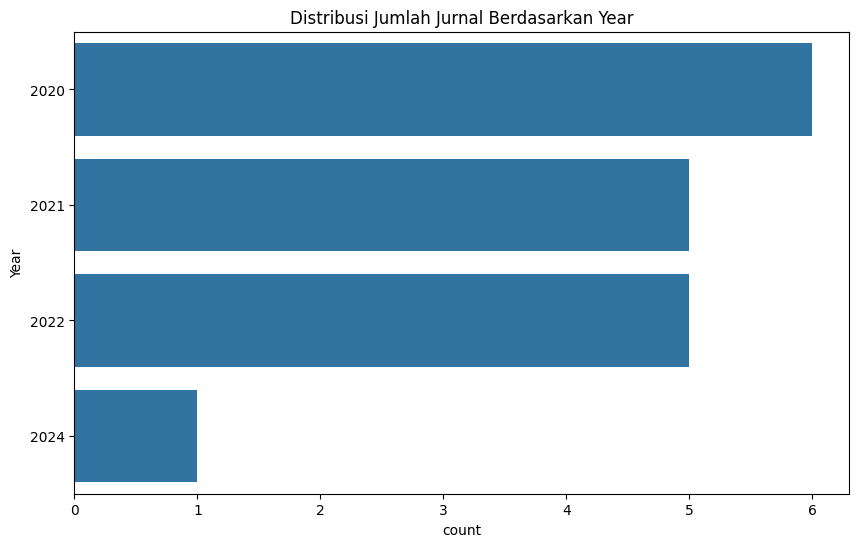

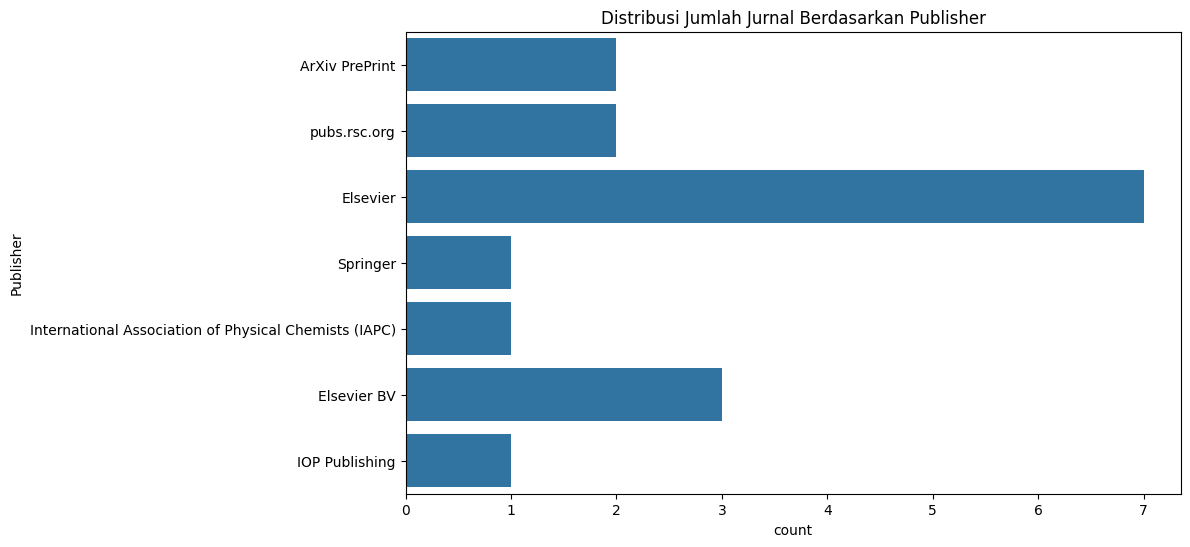

Year,2020,2021,2022,2024,Subtotal
Publisher,,,,,
ArXiv PrePrint,0,1,0,1,2
Elsevier,4,2,1,0,7
Elsevier BV,0,1,2,0,3
IOP Publishing,1,0,0,0,1
International Association of Physical Chemists (IAPC),0,0,1,0,1
Springer,1,0,0,0,1
pubs.rsc.org,0,1,1,0,2
Grandtotal,6,5,5,1,17


In [ ]:

# menampilkan jumlah publikasi per tahun dan publisher
stats = Statistics(all_with_ai_info)


pivot_table = stats.plot_distribution()
pivot_table

In [ ]:
# sort data by citation
cit_sorted_df = stats.sort_by_citation()
cit_sorted_df

# uncomment perintah dibawah untuk export ke excel
# cit_sorted_df.to_excel('cit_sorted_df.xlsx', index=False)

,Title,Link,Abstract,Year,Author,Publisher,Citation,Source,Info AI,Keywords AI
4,Recent advances and challenges in biomass-deri...,https://www.sciencedirect.com/science/article/...,… A reasonable processing method is a prerequi...,2020,,Elsevier,342,scholar,None,nanomaterials; supercapacitors; low-cost; effi...
8,Biomass derived carbon for supercapacitor appl...,https://www.sciencedirect.com/science/article/...,… During the charging and discharging of super...,2021,"P Chand, A Joshi",Elsevier,299,scholar,None,tea leaves; pore size; charging; discharging; ...
7,A new biomass derived rod-like porous carbon f...,https://www.sciencedirect.com/science/article/...,… findings suggest that the prepared biomass p...,2020,"A Khan, J Pan, S Osman, Y Sun",Elsevier,209,scholar,None,tea-waste; sustainable energy material; rod-li...
6,Ultrahigh surface area biomass derived 3D hier...,https://www.sciencedirect.com/science/article/...,… The intrinsic properties of carbon electrode...,2021,"AR Selvaraj, HJ Kim, K Senthil",Elsevier,199,scholar,None,Ultrahigh surface area; 3D hierarchical; nanos...
2,Biomass-derived porous carbon materials: synth...,https://pubs.rsc.org/en/content/articlehtml/20...,… A reasonable processing method is thus of gr...,2022,D Li,pubs.rsc.org,190,scholar,None,supercapacitors; electrode materials; porous c...
3,Recent progress on biomass waste derived activ...,https://www.sciencedirect.com/science/article/...,… The capacitance of a supercapacitor depends ...,2022,"P Manasa, S Sambasivam, F Ran",Elsevier,163,scholar,None,supercapacitors; self-doped; porous carbon; PC...
11,Sustainable electrode material for high-energy...,https://pubs.rsc.org/en/content/articlehtml/20...,"… In this work, various graphene-like porous c...",2021,"N Atar, ML Yola",pubs.rsc.org,122,scholar,None,graphene-like porous carbon; three-dimensional...
9,Ultrahigh yield of nitrogen doped porous carbo...,https://www.sciencedirect.com/science/article/...,"… Therefore, the porous carbon electrode obtai...",2020,X Shen,Elsevier,105,scholar,None,ultrahigh yield; nitrogen doped; green activat...
10,Optimization of hierarchical porous carbon der...,https://www.sciencedirect.com/science/article/...,… Activated carbons (ACs) with large surface a...,2020,"AA Hor, SA Hashmi",Elsevier,87,scholar,None,hierarchical porous carbon; pollen-cone; high-...
5,Biomass-derived porous carbon electrodes for h...,https://link.springer.com/article/10.1007/s108...,… These carbons exhibited a high specific capa...,2020,"S Dong, Y Zhang",Springer,83,scholar,None,high-performance; capacitance; material; speci...


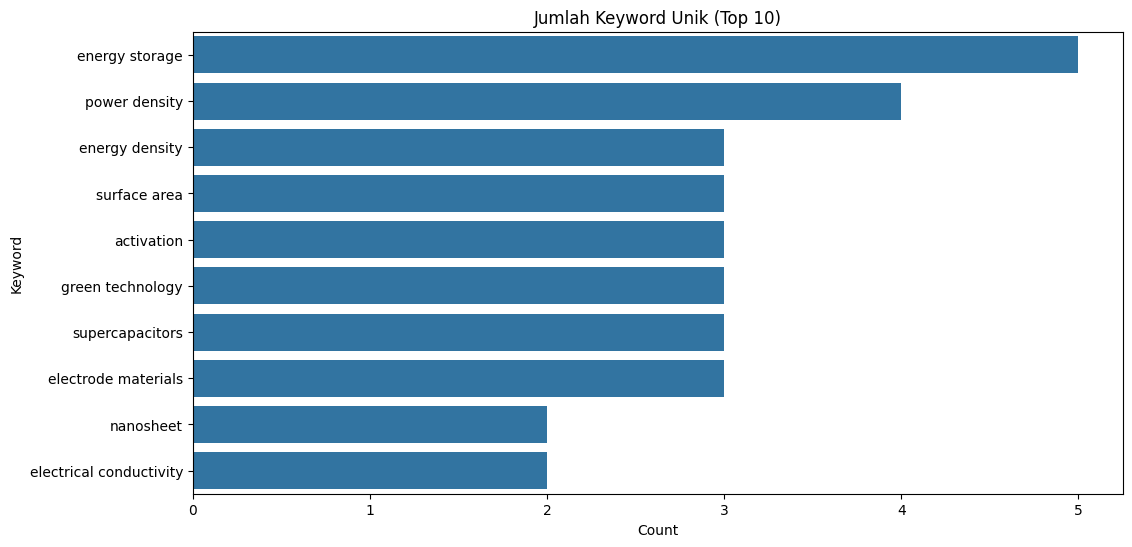

,Keyword,Count
0,energy storage,5
1,power density,4
2,energy density,3
3,surface area,3
4,activation,3
...,...,...
175,sustainability,1
176,renewable,1
177,nanostructure,1
178,interface,1


In [ ]:
# cek list keyword yang dibuat oleh ai
ai_keyword_counts = stats.keywords_analysis()
ai_keyword_counts

# uncomment perintah dibawah untuk export ke excel
# ai_keyword_counts.to_excel('ai_keyword_counts.xlsx', index=False)

In [ ]:
keyword_filtered_df = stats.filter_by_keyword('supercapacitor')
keyword_filtered_df

# uncomment perintah dibawah untuk export ke excel
# keyword_filtered_df.to_excel('keyword_filtered_df.xlsx', index=False)

,Title,Link,Abstract,Year,Author,Publisher,Citation,Source,Info AI,Keywords AI
2,Biomass-derived porous carbon materials: synth...,https://pubs.rsc.org/en/content/articlehtml/20...,… A reasonable processing method is thus of gr...,2022,D Li,pubs.rsc.org,190,scholar,None,supercapacitors; electrode materials; porous c...
3,Recent progress on biomass waste derived activ...,https://www.sciencedirect.com/science/article/...,… The capacitance of a supercapacitor depends ...,2022,"P Manasa, S Sambasivam, F Ran",Elsevier,163,scholar,None,supercapacitors; self-doped; porous carbon; PC...
4,Recent advances and challenges in biomass-deri...,https://www.sciencedirect.com/science/article/...,… A reasonable processing method is a prerequi...,2020,,Elsevier,342,scholar,None,nanomaterials; supercapacitors; low-cost; effi...
7,A new biomass derived rod-like porous carbon f...,https://www.sciencedirect.com/science/article/...,… findings suggest that the prepared biomass p...,2020,"A Khan, J Pan, S Osman, Y Sun",Elsevier,209,scholar,None,tea-waste; sustainable energy material; rod-li...
10,Optimization of hierarchical porous carbon der...,https://www.sciencedirect.com/science/article/...,… Activated carbons (ACs) with large surface a...,2020,"AA Hor, SA Hashmi",Elsevier,87,scholar,None,hierarchical porous carbon; pollen-cone; high-...
11,Sustainable electrode material for high-energy...,https://pubs.rsc.org/en/content/articlehtml/20...,"… In this work, various graphene-like porous c...",2021,"N Atar, ML Yola",pubs.rsc.org,122,scholar,None,graphene-like porous carbon; three-dimensional...
17,A High Potential of Biomass Leaves Waste for P...,https://doi.org/10.1088/1742-6596/1655/1/012007,<jats:title>Abstract</jats:title>\n ...,2020,"Apriwandi, ; Agustino, ; Taer, Erman; Taslim, ...",IOP Publishing,0,crossref,Berikut adalah poin-poin penting dari paper te...,nanofiber; nanosheet; leaves waste; pyrolysis;...
